In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder

In [3]:
train_data = pd.read_csv('C:/Users/MSI/Downloads/train.csv')
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
test_data = pd.read_csv('C:/Users/MSI/Downloads/test.csv')
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
X_train = train_data.drop(columns=['PassengerId', 'Survived','Name', 'Ticket', 'Cabin'], axis=1)
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S


In [6]:
X_test = test_data.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
X_test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,34.5,0,0,7.8292,Q
1,3,female,47.0,1,0,7.0000,S
2,2,male,62.0,0,0,9.6875,Q
3,3,male,27.0,0,0,8.6625,S
4,3,female,22.0,1,1,12.2875,S


In [7]:
y_train = train_data.Survived
y_train

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64

#### Предобработка данных

В качестве baseline-модели будем использовать решающие деревья. К сожалению, в scikit-learn реализация алгоритма решающего дерева не умеет работать с категориальными переменными, поэтому нужно преобразовать их строковое представление в числовое. Для этого используем класс LabelEncoder из sklearn. Стоит отметить, что для labeling-a записей с его помощью, данные не должны содержать пропусков. Поэтому, вначале заполним nan-ы для переменной Embarked самым часто встречающимся классом 'S'.

In [220]:
X_train['Embarked'].values
X_train['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [8]:
def preprocess_embarked(X_train):
    X_train['Embarked'].fillna('S', inplace=True)
    le = LabelEncoder()
    X_train['Embarked'] = le.fit_transform(X_train['Embarked'])
    return X_train
X_train = preprocess_embarked(X_train)
X_train

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,2
1,1,female,38.0,1,0,71.2833,0
2,3,female,26.0,0,0,7.9250,2
3,1,female,35.0,1,0,53.1000,2
4,3,male,35.0,0,0,8.0500,2
...,...,...,...,...,...,...,...
886,2,male,27.0,0,0,13.0000,2
887,1,female,19.0,0,0,30.0000,2
888,3,female,NaN,1,2,23.4500,2
889,1,male,26.0,0,0,30.0000,0


In [10]:
le = LabelEncoder()
X_test['Embarked'] = le.fit_transform(test_data['Embarked'])
X_test

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,34.5,0,0,7.8292,1
1,3,female,47.0,1,0,7.0000,2
2,2,male,62.0,0,0,9.6875,1
3,3,male,27.0,0,0,8.6625,2
4,3,female,22.0,1,1,12.2875,2
...,...,...,...,...,...,...,...
413,3,male,NaN,0,0,8.0500,2
414,1,female,39.0,0,0,108.9000,0
415,3,male,38.5,0,0,7.2500,2
416,3,male,NaN,0,0,8.0500,2


Аналогично для переменной sex:

In [11]:
X_train['Sex'] = le.fit_transform(X_train['Sex'])
X_train

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,1,22.0,1,0,7.2500,2
1,1,0,38.0,1,0,71.2833,0
2,3,0,26.0,0,0,7.9250,2
3,1,0,35.0,1,0,53.1000,2
4,3,1,35.0,0,0,8.0500,2
...,...,...,...,...,...,...,...
886,2,1,27.0,0,0,13.0000,2
887,1,0,19.0,0,0,30.0000,2
888,3,0,NaN,1,2,23.4500,2
889,1,1,26.0,0,0,30.0000,0


In [12]:
X_test['Sex'] = le.fit_transform(X_test['Sex'])
X_test

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,1,34.5,0,0,7.8292,1
1,3,0,47.0,1,0,7.0000,2
2,2,1,62.0,0,0,9.6875,1
3,3,1,27.0,0,0,8.6625,2
4,3,0,22.0,1,1,12.2875,2
...,...,...,...,...,...,...,...
413,3,1,NaN,0,0,8.0500,2
414,1,0,39.0,0,0,108.9000,0
415,3,1,38.5,0,0,7.2500,2
416,3,1,NaN,0,0,8.0500,2


Для остальных количественных переменных сделаем то же самое, заполнив пропуски медианным значением:

In [13]:
median_age = X_train['Age'].median()
median_age

28.0

In [14]:
X_train['Age'] = X_train['Age'].apply(lambda x: median_age if np.isnan(x) else x)
X_train

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,1,22.0,1,0,7.2500,2
1,1,0,38.0,1,0,71.2833,0
2,3,0,26.0,0,0,7.9250,2
3,1,0,35.0,1,0,53.1000,2
4,3,1,35.0,0,0,8.0500,2
...,...,...,...,...,...,...,...
886,2,1,27.0,0,0,13.0000,2
887,1,0,19.0,0,0,30.0000,2
888,3,0,28.0,1,2,23.4500,2
889,1,1,26.0,0,0,30.0000,0


In [15]:
X_test['Age'] = X_test['Age'].apply(lambda x: median_age if np.isnan(x) else x)
X_test

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,1,34.5,0,0,7.8292,1
1,3,0,47.0,1,0,7.0000,2
2,2,1,62.0,0,0,9.6875,1
3,3,1,27.0,0,0,8.6625,2
4,3,0,22.0,1,1,12.2875,2
...,...,...,...,...,...,...,...
413,3,1,28.0,0,0,8.0500,2
414,1,0,39.0,0,0,108.9000,0
415,3,1,38.5,0,0,7.2500,2
416,3,1,28.0,0,0,8.0500,2


#### Деревья решений

Мы заполнили пропуски в данных, убрали ненужные колонки, теперь начнём обучение.

Создадим решающее дерево и подберём его параметры при помощи решетчатого поиска:

In [123]:
clf = tree.DecisionTreeClassifier()
parameters = {'criterion': ['entropy', 'gini'],
              'max_depth': range(1, 20),
             'min_samples_split': range(2, 20),
             'min_samples_leaf': range(1, 10)}
grid_search_clf = GridSearchCV(clf, parameters, cv=5)

In [124]:
grid_search_clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': range(1, 20),
                         

In [125]:
best_estimator = grid_search_clf.best_estimator_
grid_search_clf.best_params_

{'criterion': 'entropy',
 'max_depth': 9,
 'min_samples_leaf': 5,
 'min_samples_split': 5}

[Text(163.30088619402986, 206.56799999999998, 'X[1] <= 0.5\nentropy = 0.961\nsamples = 891\nvalue = [549, 342]'),
 Text(75.57985074626866, 184.824, 'X[0] <= 2.5\nentropy = 0.824\nsamples = 314\nvalue = [81, 233]'),
 Text(27.48358208955224, 163.07999999999998, 'X[5] <= 28.856\nentropy = 0.299\nsamples = 170\nvalue = [9, 161]'),
 Text(14.991044776119404, 141.336, 'X[2] <= 23.5\nentropy = 0.469\nsamples = 70\nvalue = [7, 63]'),
 Text(9.99402985074627, 119.592, 'entropy = 0.0\nsamples = 15\nvalue = [0, 15]'),
 Text(19.98805970149254, 119.592, 'X[2] <= 27.5\nentropy = 0.55\nsamples = 55\nvalue = [7, 48]'),
 Text(9.99402985074627, 97.848, 'X[2] <= 24.5\nentropy = 0.845\nsamples = 11\nvalue = [3, 8]'),
 Text(4.997014925373135, 76.10399999999998, 'entropy = 0.65\nsamples = 6\nvalue = [1, 5]'),
 Text(14.991044776119404, 76.10399999999998, 'entropy = 0.971\nsamples = 5\nvalue = [2, 3]'),
 Text(29.982089552238808, 97.848, 'X[2] <= 37.0\nentropy = 0.439\nsamples = 44\nvalue = [4, 40]'),
 Text(24.9

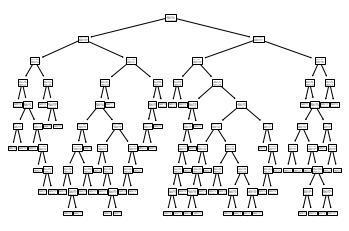

In [126]:
tree.plot_tree(best_estimator)

При попытке предсказать данные на тестовой выборке, внезапно оказалось, что некоторые наши колонки до сих пор содержат NaN-ы (удивительно, правда?!?!?!?!??!), очистим их тем же способом, что и раньше, и предскажем результат:

In [27]:
median_fare = X_test['Fare'].median()
X_test['Fare'] = X_test['Fare'].apply(lambda x: median_age if np.isnan(x) else x)
#X_test['Fare'].values

Предскажем класс пассажиров, сохраним результат:

In [155]:
predictions = best_estimator.predict(X_test)

In [156]:
predictions = pd.DataFrame(predictions, columns=['Survived'])
predictions

,Survived
0,0
1,0
2,0
3,0
4,1
...,...
413,0
414,1
415,0
416,0


Теперь сделаем submission-таблицу, где будет id пассажира и предсказанный нами класс. Для этого сконкатенируем две таблицы:

In [172]:
#result = test_data[test_data['PassengerId']].concat(predictions, axis=1)
result = pd.DataFrame(test_data['PassengerId'])
result = pd.concat([result, predictions], axis=1)
result.index += 1
result

,PassengerId,Survived
1,892,0
2,893,0
3,894,0
4,895,0
5,896,1
...,...,...
414,1305,0
415,1306,1
416,1307,0
417,1308,0


In [180]:
result.to_csv(path_or_buf='C:/Users/MSI/Desktop/Data Science/submission.csv', sep=',', index=False)

Получили точность 76.555 на Leaderbord-e

Если построить дерево, то будет видно, что оно довольно переобученное, модель определённо не лучшая

Посмотрим на важность признаков:

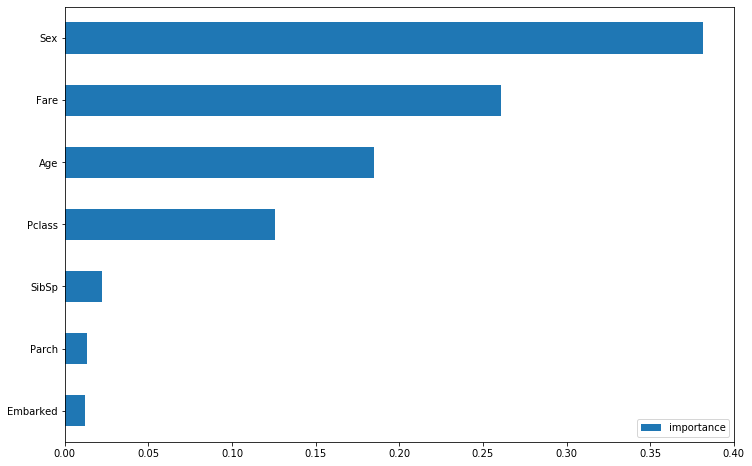

In [192]:
imp = pd.DataFrame(best_estimator.feature_importances_, index=X_test.columns, columns=['importance'])
imp.sort_values('importance').plot(kind='barh', figsize=(12, 8))

In [193]:
imp

,importance
Pclass,0.125516
Sex,0.381306
Age,0.184770
SibSp,0.022415
Parch,0.013118
Fare,0.260623
Embarked,0.012252


Ещё немного поиграем с решающими деревьями: уберём переменные, сыгравшие наименьшую роль при классификации: Embarked и Parch, потом заново обучим ту же модель с теми же параметрами, после чего посмотрим на результат:

In [234]:
X_train_temp = X_train
X_train = X_train.drop(columns=['Embarked', 'Parch'], axis=1)

In [266]:
X_test_temp = X_test
X_test = X_test.drop(columns=['Embarked', 'Parch'], axis=1)

In [201]:
clf = tree.DecisionTreeClassifier()
parameters = {'criterion': ['entropy', 'gini'],
              'max_depth': range(1, 20),
             'min_samples_split': range(2, 10),
             'min_samples_leaf': range(1, 10)}
grid_search_clf = GridSearchCV(clf, parameters, cv=5)

In [202]:
grid_search_clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': range(1, 20),
                         

In [204]:
best_estimator = grid_search_clf.best_estimator_
grid_search_clf.best_params_

{'criterion': 'entropy',
 'max_depth': 9,
 'min_samples_leaf': 5,
 'min_samples_split': 3}

[Text(166.6906779661017, 206.56799999999998, 'X[1] <= 0.5\nentropy = 0.961\nsamples = 891\nvalue = [549, 342]'),
 Text(77.6707627118644, 184.824, 'X[0] <= 2.5\nentropy = 0.824\nsamples = 314\nvalue = [81, 233]'),
 Text(31.210169491525424, 163.07999999999998, 'X[4] <= 28.856\nentropy = 0.299\nsamples = 170\nvalue = [9, 161]'),
 Text(17.023728813559323, 141.336, 'X[2] <= 23.5\nentropy = 0.469\nsamples = 70\nvalue = [7, 63]'),
 Text(11.349152542372881, 119.592, 'entropy = 0.0\nsamples = 15\nvalue = [0, 15]'),
 Text(22.698305084745762, 119.592, 'X[2] <= 27.5\nentropy = 0.55\nsamples = 55\nvalue = [7, 48]'),
 Text(11.349152542372881, 97.848, 'X[4] <= 19.875\nentropy = 0.845\nsamples = 11\nvalue = [3, 8]'),
 Text(5.6745762711864405, 76.10399999999998, 'entropy = 0.65\nsamples = 6\nvalue = [1, 5]'),
 Text(17.023728813559323, 76.10399999999998, 'entropy = 0.971\nsamples = 5\nvalue = [2, 3]'),
 Text(34.047457627118646, 97.848, 'X[2] <= 37.0\nentropy = 0.439\nsamples = 44\nvalue = [4, 40]'),
 Te

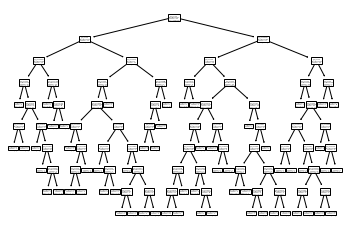

In [205]:
tree.plot_tree(best_estimator)

In [299]:
predictions = best_estimator.predict(X_test)

ValueError: Number of features of the model must match the input. Model n_features is 5 and input n_features is 7 

In [208]:
predictions = pd.DataFrame(predictions, columns=['Survived'])
result = pd.DataFrame(test_data['PassengerId'])
result = pd.concat([result, predictions], axis=1)

,PassengerId,Survived
1,892,0
2,893,0
3,894,0
4,895,0
5,896,1
...,...,...
414,1305,0
415,1306,1
416,1307,0
417,1308,0


In [209]:
result.to_csv(path_or_buf='C:/Users/MSI/Desktop/Data Science/submission.csv', sep=',', index=False)

Точность выросла до 0.77511, что поднимает сабмит в лидерборде примерно на 3 тысячи мест

#### Random forest

Оставим в покое решающие деревья и попробуем их комбинацию - случайный лес

In [210]:
rf = RandomForestClassifier()
parameters = {'n_estimators': range(2, 41, 5),
             'max_depth': range(1, 20),
             'min_samples_split': range(2, 10),
             'min_samples_leaf': range(1, 10)}

In [211]:
rf_grid_clf = GridSearchCV(rf, parameters, cv=5)

In [212]:
rf_grid_clf.fit(X_train, y_train)

C:\Users\MSI\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [214]:
rf_grid_clf.best_params_

{'max_depth': 10,
 'min_samples_leaf': 3,
 'min_samples_split': 7,
 'n_estimators': 32}

In [215]:
best_estimator_rf = rf_grid_clf.best_estimator_

In [216]:
predictions = best_estimator_rf.predict(X_test)

In [217]:
predictions = pd.DataFrame(predictions, columns=['Survived'])
result = pd.DataFrame(test_data['PassengerId'])
result = pd.concat([result, predictions], axis=1)

In [218]:
result.to_csv(path_or_buf='C:/Users/MSI/Desktop/Data Science/submission.csv', sep=',', index=False)

Точность упала до 76.555, как было на одном решающем дереве. Это не стоило этих 20-ти минут

Вернём удалённые колонки и обучим лес снова, с немного другими параметрами

In [267]:
X_train = X_train_temp
X_test = X_test_temp

In [293]:
rf = RandomForestClassifier()
parameters = {'n_estimators': range(10, 30, 4),
             'max_depth': range(1, 15),
             'min_samples_split': range(4, 10),
             'min_samples_leaf': range(1, 8)}

In [294]:
rf_grid_clf = GridSearchCV(rf, parameters, cv=5, n_jobs=-1)

In [295]:
rf_grid_clf.fit(X_train, y_train)

C:\Users\MSI\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [296]:
best_estimator_rf = rf_grid_clf.best_estimator_
rf_grid_clf.best_params_

{'max_depth': 14,
 'min_samples_leaf': 2,
 'min_samples_split': 4,
 'n_estimators': 10}

In [297]:
predictions = best_estimator_rf.predict(X_test)
best_estimator_rf.score(X_train, y_train)

0.9046015712682379

In [286]:
predictions = pd.DataFrame(predictions, columns=['Survived'])
result = pd.DataFrame(test_data['PassengerId'])
result = pd.concat([result, predictions], axis=1)

In [287]:
result.to_csv(path_or_buf='C:/Users/MSI/Desktop/Data Science/submission.csv', sep=',', index=False)

#### Итог на сейчас

Случайный лес из нескольких деревьев не дал результат лучше, чем одно решающее дерево

In [144]:
X_train['FamSize'] = X_train['SibSp'] + X_train['Parch']
X_train_temp = X_train
X_train.drop(columns=['SibSp', 'Parch'], inplace=True)
X_train

,Pclass,Sex,Age,Fare,Embarked,FamSize
0,3,1,22.0,7.2500,2,1
1,1,0,38.0,71.2833,0,1
2,3,0,26.0,7.9250,2,0
3,1,0,35.0,53.1000,2,1
4,3,1,35.0,8.0500,2,0
...,...,...,...,...,...,...
886,2,1,27.0,13.0000,2,0
887,1,0,19.0,30.0000,2,0
888,3,0,28.0,23.4500,2,3
889,1,1,26.0,30.0000,0,0


In [145]:
X_test['FamSize'] = X_test['SibSp'] + X_test['Parch']
X_test_temp = X_test
X_test.drop(columns=['SibSp', 'Parch'], inplace=True)
X_test

,Pclass,Sex,Age,Fare,Embarked,FamSize
0,3,1,34.5,7.8292,1,0
1,3,0,47.0,7.0000,2,1
2,2,1,62.0,9.6875,1,0
3,3,1,27.0,8.6625,2,0
4,3,0,22.0,12.2875,2,2
...,...,...,...,...,...,...
413,3,1,28.0,8.0500,2,0
414,1,0,39.0,108.9000,0,0
415,3,1,38.5,7.2500,2,0
416,3,1,28.0,8.0500,2,0


In [169]:
rf = RandomForestClassifier()
parameters = {'criterion': ['gini', 'entropy'],
              'n_estimators': range(1, 20),
             'max_depth': range(1, 20),
             'min_samples_split': range(2, 20),
             'min_samples_leaf': range(1, 20),
             }

In [170]:
rf_grid_clf = RandomizedSearchCV(rf, parameters, cv=5, n_jobs=-1)

In [171]:
rf_grid_clf.fit(X_train, y_train)

C:\Users\MSI\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [172]:
best_estimator = rf_grid_clf.best_estimator_
rf_grid_clf.best_params_

{'n_estimators': 18,
 'min_samples_split': 4,
 'min_samples_leaf': 16,
 'max_depth': 19,
 'criterion': 'gini'}

In [173]:
predictions = best_estimator.predict(X_test)
best_estimator.score(X_train, y_train)

0.8282828282828283

In [66]:
predictions = pd.DataFrame(predictions, columns=['Survived'])
result = pd.DataFrame(test_data['PassengerId'])
result = pd.concat([result, predictions], axis=1)

In [67]:
result.to_csv(path_or_buf='C:/Users/MSI/Desktop/Data Science/submission.csv', sep=',', index=False)